## MIT bag EOS emcee workflow

emcee is an open-source Python library designed for MCMC sampling. Here's how it operates:

1. Walkers: emcee uses multiple "walkers" that explore the parameter space. Each walker represents a point in the parameter space and moves around based on the probabilities defined by the log likelihood and log prior.


2. Sampling Process: During each step, each walker proposes a new position based on its current position and a set of random perturbations. The new position is then accepted or rejected based on the Metropolis-Hastings criterion, which ensures that points with higher probabilities are more likely to be accepted.


3. Convergence: Over many iterations, the walkers explore the parameter space, allowing for convergence to the posterior distribution of the parameters. After a sufficient number of steps, the samples from the walkers can be used to estimate the posterior distributions and uncertainties of the parameters.

### Defining the Constants 

In [14]:
import numpy as np
import TOVsolver.main as main
import InferenceWorkflow.prior as prior
import InferenceWorkflow.Likelihood as likelihood

fm = 1
hbarc = 0.197327053
c = 1  # speed of light
hbar = 1  # reduced Planck constant

GeV = 1 / hbarc  # Giga-electronvolt
MeV = 1e-3 * GeV  # Mega-electronvolt

g = 5.625e26 * MeV  # gram
kg = 1e3 * g  # kilogram
cm = 1e13 * fm  # centimeter
m = 100 * cm  # meter
km = 1e5 * cm  # kilometer
s = 3e10 * cm  # second

dyn = g * cm / s**2  # dyne
dyn_cm_2 = dyn / cm**2  # dyne / cm^2
g_cm_3 = g / cm**3  # gram / cm^3
erg = dyn * cm  # ἐργον energy unit

m_n = 939.565 * MeV  # mass of neutron
n0 = 0.16 / fm**3  # saturation density

e0 = m_n * n0  # saturation energy density
G = 6.6743e-8 * dyn * cm**2 / g**2  # gravitational constant
Msun = 1.989e33 * g  # mass of sun



### MIT Bag EOS

In [ ]:

def MITbag_compute_EOS(B): 
    """
    Compute the energy density and pressure based on the given parameters.

    Args:
        B: Input value of bag constant; MeVfm^-3
        
    Returns:
        tuple: Arrays of energy densities in units of gcm^3 and pressures in units of dyncm^2.
    """
    
    B_cgs = B * (MeV / (fm)**3) # converting input to cgs
    energy_density  = np.linspace(4 * B_cgs, 10 * B_cgs, 1000) # cgs
    # epsilon has a minimum value of 4B so that pressure >= 0
    
    pressure = ((energy_density / 3) - (4 * B_cgs / 3))
    
    return energy_density, pressure

In [ ]:
parameters = ['B','d1']


# def prior_transform(cube):
#     params = cube.copy()
#     params[0] = prior.flat_prior(20, 100, cube[0])  # Prior for B

#     B = params[0]
#     epsilon, p = MITbag_compute_EOS(B)

#     RFSU2R = [] 
#     MFSU2R = []
#     density = np.logspace(14.3, 15.6, 50) 

#     # Check if energy density and pressure are monotonically increasing
#     if all(x < y for x, y in zip(epsilon[:-1], epsilon[1:])) and all(x < y for x, y in zip(p[:-1], p[1:])):
#         MR = main.OutputMR("", epsilon, p).T  
#     else:
#         MR = None  # Explicitly set MR to None if the condition fails

#     if MR is None or len(MR) == 0: 
#         params[1] = 0
#     else:
#         for i in range(len(MR[1])):
#             RFSU2R.append(MR[1][i])
#             MFSU2R.append(MR[0][i])   
#             if i > 20 and MR[0][i] - MR[0][i-1] < 0:    
#                 break
#     if len(MFSU2R) == 0:
#         params[1] = 0
#     else:
#         max_index = len(MFSU2R)
#         max_d = np.log10(density[max_index - 1])
#         params[1] = 14.3 + (max_d - 14.3) * cube[1]

#     return params


In [6]:
import InferenceWorkflow.Likelihood as likelihood

### Defining the Likelihood 

This function computes the likelihood of the model given the parameters. It calls the functions to compute the equation of state and retrieves the mass-radius relation. Then, it calculates the likelihood based on observed data.

In [7]:
import scipy.stats as stats


def likelihood_transform(theta):
    # This is a demonstration code for only introduce one constraint from one mass-radius observation.
    # Could be very easy to implement more constraint from nuclear quantity, since that do not need to
    # sample more central density of real neutron star. If user want to expand to two mass radius measurement 
    # the code could be:
      
    B, d1 = theta
    
    ####################################################################################################################
    ############ This is the block to compute out all the EoS you need based on your parameters#########################

    epsilon,p = MITbag_compute_EOS(B)

    ####################################################################################################################
    
    probMRgaussian = likelihood.MRlikihood_Gaussian(epsilon,p,(1.4,13,0.07,0.65),d1)
    
    prob = probMRgaussian
    
    return prob

### Defining the Prior

This function defines the log prior probability for the parameters. The prior is flat within specified bounds. If the parameters fall outside these bounds, the function returns 
−∞, indicating that the parameters are not valid.

In [8]:
def prior_transform(cube):
    """
    Transforms a unit cube sample into the parameter space.

    Args:
        cube: Array of samples from the unit cube [0, 1]^N.

    Returns:
        Array of transformed parameters.
    """
    params = cube.copy()
    params[0] = prior.flat_prior(20, 100, cube[0])  # Prior for B

    B = params[0]
    epsilon, p = MITbag_compute_EOS(B)

    RFSU2R = [] 
    MFSU2R = []
    density = np.logspace(14.3, 15.6, 50) 

    # Check if energy density and pressure are monotonically increasing
    if all(x < y for x, y in zip(epsilon[:-1], epsilon[1:])) and all(x < y for x, y in zip(p[:-1], p[1:])):
        MR = main.OutputMR("", epsilon, p).T  
    else:
        MR = []

    # Handle MR assignment
    if not MR: 
        params[1] = 0
    else:
        for i in range(len(MR[1])):
            RFSU2R.append(MR[1][i])
            MFSU2R.append(MR[0][i])   
            if i > 20 and MR[0][i] - MR[0][i-1] < 0:    
                break

        if not MFSU2R:
            params[1] = 0
        else:
            max_index = len(MFSU2R)
            max_d = np.log10(density[max_index - 1])
            params[1] = 14.3 + (max_d - 14.3) * cube[1]

    return params


### Running EMCEE 

This block initializes the MCMC sampler. It defines the number of walkers (simultaneous sampling processes) and the number of parameters being estimated. It generates random initial positions for each walker within specified bounds.

Running MCMC...


100%|██████████| 500/500 [00:06<00:00, 73.67it/s]


MCMC complete.


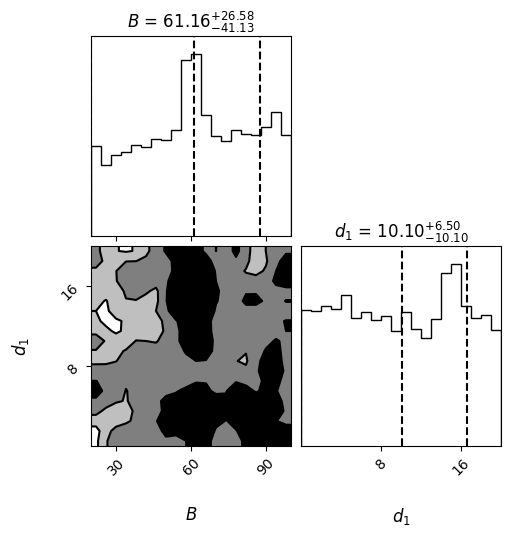

In [12]:
import numpy as np
import emcee  # Import emcee for MCMC sampling
import corner
import matplotlib.pyplot as plt  # For plotting
import math

# Constants and settings
fm = 1
hbarc = 0.197327053
g = 5.625e26 * (1e-3 * (1 / hbarc))  # gram in MeV
g_cm_3 = g / (1e13 * fm)**3  # gram / cm^3
Msun = 1.989e33 * g  # mass of sun

# Number of parameters
ndim = 2  # Number of parameters: B and d1
nwalkers = 30  # Should be at least 2 * ndim

# Initial guesses for the parameters
initial_guess = np.array([60, 15.0])  # Example initial guesses for B and d1

# Function to compute the log prior
def log_prior(params):
    B, d1 = params
    if 20 < B < 100 and 0 < d1 < 20:
        return 0.0  # Uniform prior
    return -np.inf  # Outside prior bounds

# Function to compute the likelihood
def likelihood_transform(theta):
    B, d1 = theta
    epsilon, p = MITbag_compute_EOS(B)  # Assuming MITbag_compute_EOS is defined

    probMRgaussian = likelihood.MRlikihood_Gaussian(epsilon, p, (1.4, 13, 0.07, 0.65), d1)  # Assuming this is defined
    return probMRgaussian

# Combined log probability function
def log_probability(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + likelihood_transform(params)

# Function to sample initial positions
def sample_initial_positions(nwalkers, ndim):
    positions = []
    while len(positions) < nwalkers:
        pos = initial_guess + 1e-2 * np.random.randn(ndim)  # Small random perturbation
        if np.isfinite(log_prior(pos)):
            positions.append(pos)
    return np.array(positions)

# Generate initial positions for the walkers
p0 = sample_initial_positions(nwalkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Number of steps for MCMC
nsteps = 500  # Set to 50 as per your request

# Run MCMC
print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=True)
print("MCMC complete.")

# Extract the samples
samples = sampler.get_chain(flat=True)

# Create corner plot
labels = [r"$B$", r"$d_1$"]  # Adjust labels based on your parameters

figure = corner.corner(samples, labels=labels,
                       smooth=0.9,
                       label_kwargs=dict(fontsize=12),
                       title_kwargs=dict(fontsize=12),
                       quantiles=[0., 0.5, 0.84],
                       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                       plot_density=False,
                       plot_datapoints=False,
                       fill_contours=True,
                       show_titles=True,
                       max_n_ticks=3,
                       title_fmt='.2f')

# Save and show the corner plot
plt.savefig("corner_plot.png")
plt.show()  # Display the plot
